In [123]:
import numpy as np
import scipy
from scipy.integrate import solve_ivp
import scipy.integrate as integrate
from scipy.special import gamma, factorial, zeta, polygamma
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from scipy.signal import argrelextrema

In [124]:
def V0(phi, m, l):
    """
    The tree level potential V(phi) = -1/2 m^2 phi^2 + l/4 phi^4
    m is the tree-level mass and l the self-coupling, both should be positive

    @param phi: our scalar field, should be array
           m: the tree-level mass
           l: the self-coupling
    @return The effective potential at tree level
    """
    return -m**2*phi**2/2 + l*phi**4/4

In [125]:
def JBexact(m, T):
    """
    The exact calculation of the thermal bosonic function J_B
    J_B[m^2/T^2] = int dx x^2 log[1 - exp(-sqrt(x^2 + m^2/T^2))] int from 0 to infinity
    Used in the one-loop thermal correction to the effective potential

    @param m: the mass of the boson, should be Python scalar, i.e no array
           T: the temperature, should be Python scalar, i.e no array
    @return JB: The thermal bosonic function
    """
    # The integrand
    f = lambda x: x**2*np.log(1 - np.exp(-np.sqrt(x**2 + m**2/T**2)))

    # scipy.integrate.quad can only take python scalars as input hence no arrays
    JB = integrate.quad(f, 0, np.inf)[0]
    return JB

In [126]:
def JBhighTapprox(m, T):
    """
    The high temperature expansion of the bosonic thermal function
    J_B[m^2/T^2] = -pi^4/45 + pi^2/12*(m^2/T^2) - pi/6(m^2/T^2)^(3/2) 
                     (- 1/32*(m^2/T^2)^2 log(m^2/aB*T^2))                    aB = 16pi^2exp(3/2 - 2gamma_E), logaB = 5.4076
                            (- 2*pi^(7/2) sum(-1)^n zeta(2n+1)/(n+1)! gamma(n+1/2) (m^2/(4pi^2T^2))^(n+2) with summation over n from 1 to infinity)
                     (not yet implemented)

    @param m: the mass of the boson
           T: the temperature
    @return JBapprox: The high T-approximation of the thermal bosonic function
    """
    y = m**2/T**2
    JBapprox = -np.pi**4/45 + np.pi**2/12*y - np.pi/6*y**(3/2)
    return JBapprox
    

In [127]:
def JFexact(m, T):
    """
    The exact calculation of the fermionic thermal function J_F
    J_B[m^2/T^2] = int dx x^2 log[1 + exp(-sqrt(x^2 + m^2/T^2))] int from 0 to infinity
    Used in the one-loop thermal correction to the effective potential

    @param m: the mass of the fermion, should be Python scalar, i.e no array
           T: the temperature, should be Python scalar, i.e no array
    @return JF: The thermal fermionic function
    """
    # The integrand
    f = lambda x: x**2*np.log(1 + np.exp(-np.sqrt(x**2 + m**2/T**2)))

    # scipy.integrate.quad can only take python scalars as input hence no arrays
    JF = integrate.quad(f, 0, np.inf)[0]
    return JF

In [128]:
def JFhighTapprox(m, T):
    """
    The high temperature expansion of the fermionic thermal function
    J_B[m^2/T^2] = 7pi^4/360 - pi^2/24*(m^2/T^2)  
                     (- 1/32*(m^2/T^2)^2 log(m^2/aF*T^2))                    aF = pi^2exp(3/2 - 2gamma_E), logaF = 2.6351
                            (- pi^(7/2)/4 sum((-1)^n zeta(2n+1)/(n+1)! (1 - 2^(-2n-1))gamma(n+1/2) (m^2/(4pi^2T^2))^(n+2)) with summation over n from 1 to infinity)
                     (not yet implemented)

    @param m: the mass of the fermion
           T: the temperature
    @return JFapprox: The high T-approximation of the fermionic thermal function
    """
    y = m**2/T**2
    JFapprox = np.pi**4*7/360 - np.pi**2/24*y
    return JFapprox

In [286]:
def V1Texact(mB, mF, nB, nF, T):
    """
    The finite-temperature one-loop effective potential:
    
        V1T = T^4/(2pi^2)*[sum_B nB*JB(mB^2/T^2) + sum_F nF*JF(mF^2/T^2)]
            where sum_B/F sum the bosons/fermions that couples to the scalar, 
            nB/F is the degree of freedom for each boson/fermion,
            mB/F is the field dependent mass of each boson/fermion

    
    @param mB: the field dependent mass/masses of the boson/bosons, should be an array
           mF: the field dependent mass/masses of the fermion/fermions, should be an array
           nB: the degree of freedom for each boson, should be an array and equal length as mB
           nF: the degree of freedom for each fermion, should be an array and equal length as mF
           T: the temperature, should be Python scalar, i.e no array
    @return tempPotential: The finite-temperature one-loop effective potential
    """

    # For the function JBexact to work we need to recast nB to 1-D array if it is not one
    if not isinstance(nB, np.ndarray):
        nB = np.array([nB])
    
    # If only one boson add extra dim for for loops to work
    if mB.ndim == 1:
        mB = np.expand_dims(mB, axis=0)

    # To get V1T at every value of the field phi we store it in an 1-D array length of the phi/number of columns in mB
    summation = np.zeros(mB.shape[1])

    # We loop over every bosons field dependent mass which is a row in mB
    for i in range (mB.shape[0]):
        # Then loop over every field value
        for j in range(mB.shape[1]):
            summation[j] += nB[i]*JBexact(mB[i,j], T)

    if nF != 0:
        # We need to recast nF to 1-D array 
        if not isinstance(nF, np.ndarray):
            nF = np.array([nF])

        # If only one fermion add extra dim for for loops to work
        if mF.ndim == 1:
            mF = np.expand_dims(mF, axis=0)

        # Loop over every fermion
        for i in range (mF.shape[0]):
            # Then loop over every field value
            for j in range(mF.shape[1]):
                summation[j] += nF[i]*JFexact(mF[i,j], T)

    tempPotential = T**4/(2*np.pi**2)*summation
    return tempPotential


In [130]:
def Veff(mB, mF, nB, nF, T, phi, m, l):
    """
    The effective potential, the tree level potential + the finite-temperature one-loop:
        Veff(phi, T) = V0(phi) + V1T(phi, T)

    @param mB: the field dependent mass/masses of the boson/bosons, should be an array
           mF: the field dependent mass/masses of the fermion/fermions, should be an array
           nB: the degree of freedom for each boson, should be an array and equal length as mB
           nF: the degree of freedom for each fermion, should be an array and equal length as mF
           T: the temperature
           phi: our scalar field, should be array
           m: the tree-level mass of the scalar
           l: the self-coupling of the scalar
    @return The effective potential
    """
    
    return V0(phi, m, l) + V1Texact(mB, mF, nB, nF, T)

C:\Users\mvoorde\AppData\Local\Temp/ipykernel_16792/2795381531.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  f = lambda x: x**2*np.log(1 - np.exp(-np.sqrt(x**2 + m**2/T**2)))


Text(0.5, 1.0, 'T=0')

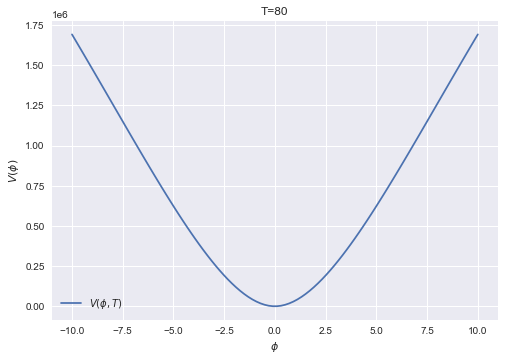

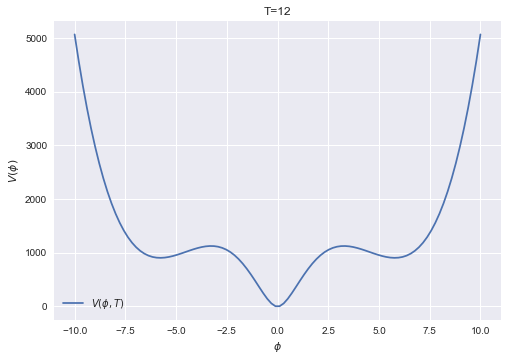

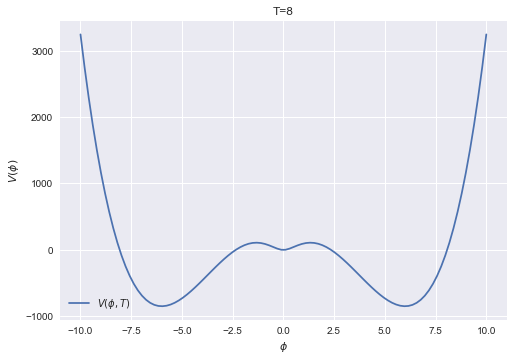

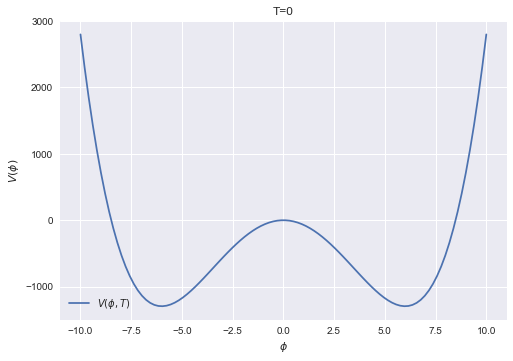

In [369]:
"""
Testing testing
"""
# Define a tree level potential V(phi) = -12^2/2*phi^2 + phi^4
m = 12
l = 4
phi_span = np.linspace(-10, 10, 100)
pot = V0(phi_span, m, l)

# Define the field dependent masses
# Needs a boson to get the term ~Tphi^3 that gives 1st order PT either phi, or add an extra boson

# Phi
# mPhi med m**2 ger ett minimum som är högerförskjutet vid höga temperaturer och vi får ej tree level potential vid T=0
# mPhi = 3*l*phi_span - m**2  # Fungerar om -m**2 tas bort
# nPhi = 1

# Extra boson
c = 24
mX = np.sqrt(c**2*phi_span**2/2**2)
nX = 1

# If we have both mX och mPhi, uncomment this
# mB = np.vstack((mPhi, mX))
# nB = np.hstack((nPhi, nX))

# Put the mass and dofs for bosons and fermions
mB = mX
nB = nX
mF = 0
nF = 0

# Plots with different temperatures

# T=80, high temperatures with one minimum, unbroken symmetry
T = 80
potT = Veff(mB, mF, nB, nF, T, phi_span, m, l)

# Put minimum in origo
constant = potT[50]
potT = potT - constant

plt.figure()
plt.plot(phi_span, potT, label='$V(\phi, T)$')
plt.legend()
plt.xlabel('$\phi$')
plt.ylabel('$V(\phi)$')
plt.title('T=80')

# T=12, temperature that gives a bump with higher local minimum
T = 12
potT = Veff(mB, mF, nB, nF, T, phi_span, m, l)

# Put minimum in origo
constant = potT[50]
potT = potT - constant

plt.figure()
plt.plot(phi_span, potT, label='$V(\phi, T)$')
plt.legend()
plt.xlabel('$\phi$')
plt.ylabel('$V(\phi)$')
plt.title('T=12')

# T=8, temperature that gives bump and lower minimum
T = 8
potT = Veff(mB, mF, nB, nF, T, phi_span, m, l)

# Put minimum in origo
constant = potT[50]
potT = potT - constant

plt.figure()
plt.plot(phi_span, potT, label='$V(\phi, T)$')
plt.legend()
plt.xlabel('$\phi$')
plt.ylabel('$V(\phi)$')
plt.title('T=8')

# T=0, should give the tree potential
T = 0
potT = Veff(mB, mF, nB, nF, T, phi_span, m, l)

plt.figure()
plt.plot(phi_span, potT, label='$V(\phi, T)$')
plt.legend()
plt.xlabel('$\phi$')
plt.ylabel('$V(\phi)$')
plt.title('T=0')



Exemplet nedan fungerar ej. Högre temperaturer sänker värdet på potentialen och höjer vev (jämfört med potentialen vid T=0) men ändrar inte formen på potentialen. Alltså vi får ingen fasövergång alls mellan "symmetrierna" (unbroken --> broken).

C:\Users\mvoorde\AppData\Local\Temp/ipykernel_16792/2795381531.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  f = lambda x: x**2*np.log(1 - np.exp(-np.sqrt(x**2 + m**2/T**2)))


[-4952848.05938802 -4952848.05938802]
113.63636363636363 -113.63636363636365
76.45727651978105
[-10415504.26189161 -10415504.26189161]
-128.7878787878788 128.78787878787875
[-45980987.01685026 -45980987.01685009]
-184.34343434343435 184.3434343434343


Text(0.5, 1.0, '$T = 150$')

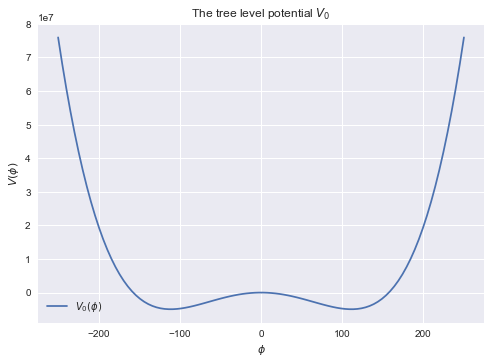

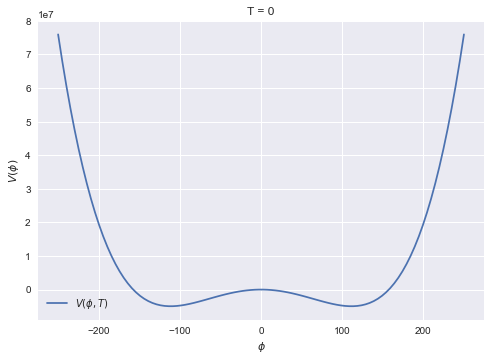

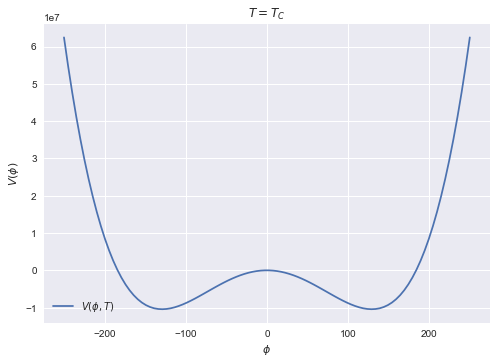

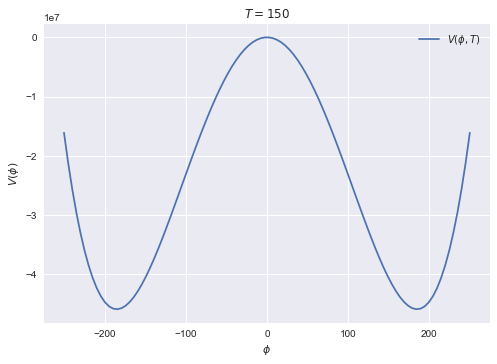

In [366]:
"""
Testing the potential from M.Quiros eq (213) or eq (223) but without the 1-loop effective potential at T=0:

    V(phi, T) = -1/4*m_h^2*phi^2 + D*T^2 - E*T*phi^3 + lambda/4*phi^4

        with D = (2*m_W^2 + m_Z^2 + 2*m_t^2)/(8v^2)
             E = (2*m_W^3 + m_Z^3)/(4pi*v^3)

This is the analytical expression using the high-T approximation and without a thermal contribution from higgs

DOES NOT WORK :((
"""
# Set tree level parameters for higgs, test som different m values, m = 125 does not work
m = 40
l = 0.129
phi_span = np.linspace(-250, 250, 100)
pot = V0(phi_span, m, l)

# First plot the tree level potential
plt.figure()
plt.plot(phi_span, pot, label='$V_0(\phi)$')
plt.legend()
plt.xlabel('$\phi$')
plt.ylabel('$V(\phi)$')
plt.title('The tree level potential $V_0$')

# Define the field dependent masses
# Bosons W and Z, from eq (81)
g1 = 0.653                  # the coupling g
mW = np.sqrt(g1**2*phi_span**2/4)
nW = 6

g2 = 0.247                  # the coupling g'
mZ = np.sqrt((g1**2 + g2**2)*phi_span**2/4)
nZ = 3

# Fermion top, from eq (82)
yt = 0.996
mt = np.sqrt(yt**2*phi_span**2/2)
nt = 12

# Stack the boson masses and dofs in two arrays
mB = np.vstack((mW, mZ))
nB = np.hstack((nW, nZ))

# And the top mass in the fermion mass array
mF = mt
nF = nt

# Potential for T = 0, should equal V0
T = 0
potT = Veff(mB, mF, nB, nF, T, phi_span, m, l)

# Find the value of the potential at the minimas
indexMinimas = argrelextrema(potT, np.less)
potMinima = potT[indexMinimas[0]]
print(potMinima)
# Find the phi minimas
indexPhiTrue =  np.argwhere(potMinima == potMinima.min())[0]
phiTrueVacuum = phi_span[indexMinimas[0]][indexPhiTrue[0]]
phiFalseVacuum = phi_span[indexMinimas[0]][~indexPhiTrue[0]]
potTrueVacuum = potMinima.min()
potFalseVacuum = potMinima.max()
print(phiTrueVacuum, phiFalseVacuum)

plt.figure()
plt.plot(phi_span, potT, label='$V(\phi, T)$')
plt.legend()
plt.xlabel('$\phi$')
plt.ylabel('$V(\phi)$')
#plt.ylim([-1e8, 1e8])
plt.title('T = 0')

# The potential at the critical temperature

# T = 0 masses for higgs mass = 125 GeV
mW0 = 80.385   #W boson mass
mZ0 = 91.1876  #Z boson mass
mh0 = 125.1    #Higgs mass 
v0 = 246.22    #Higgs VEV
mt0 = 173.34   #Top quark mass

# With higgs mass not equal 125 GeV
v0 = m/np.sqrt(2*l)

# Coefficients in eq (213)
D = (2*mW0**2 + mZ0**2 + 2*mt0**2)/(8*v0**2)
E = (2*mW0**3 + mZ0**3)/(4*np.pi*v0**3)
B = 3/(64*np.pi**2*v0**4)*(2*mW0**4 + mZ0**4 - 4*mt0**4)
Tmin2 = (m**2 -8*B*v0**2)/(4*D)

# The critical temperature according to eq (228)
TC = np.sqrt(l*D*Tmin2/(l*D - E**2))
print(TC)

T = TC
potTC = Veff(mB, mF, nB, nF, T, phi_span, m, l)

# Put minimum in origo
constant = potTC[50]
potTC = potTC - constant

indexMinimas = argrelextrema(potTC, np.less)

# Find the value of the potential at the minimas
potMinima = potTC[indexMinimas[0]]
print(potMinima)
# Find the phi minimas
indexPhiTrue =  np.argwhere(potMinima == potMinima.min())[0]
phiTrueVacuum = phi_span[indexMinimas[0]][indexPhiTrue[0]]
phiFalseVacuum = phi_span[indexMinimas[0]][~indexPhiTrue[0]]
potTrueVacuum = potMinima.min()
potFalseVacuum = potMinima.max()
print(phiTrueVacuum, phiFalseVacuum)

plt.figure()
plt.plot(phi_span, potTC, label='$V(\phi, T)$')
plt.legend()
plt.xlabel('$\phi$')
plt.ylabel('$V(\phi)$')
plt.title('$T = T_C$')

# And at higher temperatures

T = TC*2
pot = Veff(mB, mF, nB, nF, T, phi_span, m, l)

# Put minimum in origo
constant = pot[50]
pot = pot - constant

indexMinimas = argrelextrema(pot, np.less)

# Find the value of the potential at the minimas
potMinima = pot[indexMinimas[0]]
print(potMinima)
# Find the phi minimas
indexPhiTrue =  np.argwhere(potMinima == potMinima.min())[0]
phiTrueVacuum = phi_span[indexMinimas[0]][indexPhiTrue[0]]
phiFalseVacuum = phi_span[indexMinimas[0]][~indexPhiTrue[0]]
potTrueVacuum = potMinima.min()
potFalseVacuum = potMinima.max()
print(phiTrueVacuum, phiFalseVacuum)

plt.figure()
plt.plot(phi_span, pot, label='$V(\phi, T)$')
plt.legend()
plt.xlabel('$\phi$')
plt.ylabel('$V(\phi)$')
plt.title('$T = 150$')


In [392]:
def V1Tapprox(mB, mF, nB, nF, T):
    """
    The finite-temperature one-loop effective potential:
    
        V1T = T^4/(2pi^2)*[sum_B nB*JB(mB^2/T^2) + sum_F nF*JF(mF^2/T^2)]
            where sum_B/F sum the bosons/fermions that couples to the scalar, 
            nB/F is the degree of freedom for each boson/fermion,
            mB/F is the field dependent mass of each boson/fermion
    
    With the high temperature expansions of the exact JB/F functions

    @param mB: the field dependent mass/masses of the boson/bosons, should be an array
           mF: the field dependent mass/masses of the fermion/fermions, should be an array
           nB: the degree of freedom for each boson, should be an array and equal length as mB
           nF: the degree of freedom for each fermion, should be an array and equal length as mF
           T: the temperature, should be Python scalar, i.e no array
    @return tempPotential: The approximated finite-temperature one-loop effective potential
    """
    
    summation = np.zeros(nB.shape[0])

    # First calculate the JB for every boson
    JB = JBhighTapprox(mB, T)

    # First transpose s.t right dof in nB matches the boson in mB, the second transpose to get it on right form again
    summation += (nB*JB.T).T

    # Then the same for the fermions
    JF = JFhighTapprox(mF, T)
    summation += (nB*JF.T).T

    # After the summations
    tempPotential = T**4/(2*np.pi**2)*summation
    return tempPotential


In [391]:
mW = np.linspace(0,1,3)
mZ = np.linspace(0,2,3)
nW = 1
nZ = 2

mB = np.vstack((mW, mZ))
nB = np.hstack((nW, nZ))

print(mB)
print(nB)

JB = JBhighTapprox(mB, T=1)
print(JB.T)

print((JB.T*nB).T)

[[0.  0.5 1. ]
 [0.  1.  2. ]]
[1 2]
[[-2.16464647 -2.16464647]
 [-2.02447956 -1.86577821]
 [-1.86577821 -3.06356854]]
[[-2.16464647 -2.02447956 -1.86577821]
 [-4.32929293 -3.73155642 -6.12713708]]


In [393]:
def VeffApprox(mB, mF, nB, nF, T, phi, m, l):
    """
    The effective potential: the tree level potential + the finite-temperature one-loop potential:
        Veff(phi, T) = V0(phi) + V1T(phi, T)

    With the high-T approximation

    @param mB: the field dependent mass/masses of the boson/bosons, should be an array
           mF: the field dependent mass/masses of the fermion/fermions, should be an array
           nB: the degree of freedom for each boson, should be an array and equal length as mB
           nF: the degree of freedom for each fermion, should be an array and equal length as mF
           T: the temperature
           phi: our scalar field, should be array
           m: the tree-level mass of the scalar
           l: the self-coupling of the scalar
    @return The effective potential
    """
    
    return V0(phi, m, l) + V1Tapprox(mB, mF, nB, nF, T)

TO DO:
- Finite temperature potential
- Temperature corrections
- Find TC
- Euclidean action
- Calculated from TC down to Tmin (S3 --> 0)
- Find S3/T = 140 --> get Tn
- Get inverse phase transition time (beta/H)
- Get latent heat

        - fixa field dependent masses, array i 1-D/2-D till scalar i JB/Fexact -- check!
        - kolla integralen, går den att summera ihop för olika phi-värden som ger olika m-värden -- check!
        - sätta upp mB som ([e, n, b], [e, n, a, n, n, a, n])?? -- check!
        - testa med approx ist, använda phi_span men kolla specifika temperaturer
        - lägga till W, Z, t och ta bort för higgs kolla med M.Quiros --check, funkar ej!
        - fixa shootin method för TC
        - funktion för S3
        - plotta S3/T